<a href="https://colab.research.google.com/github/pgordin/GraphsSN2025/blob/main/Graphs5a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Graphs & Social Networks &mdash; lab material
This notebook contains a definition of a python class *Graph*, containing functions described during labs.

Package import.

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, seed
from copy import deepcopy

## Simple functions from the first classes
This is left just as an example (to compare the behaviour).

In [3]:
def print_matrix(vertices, matrix):
  """
  Printing a graph given by adjacency matrix
  """
  n = len(matrix)
  if (vertices is not None) and (len(vertices) == n):
    vv = vertices
  else:
    vv = range(1, n+1)
  for i in range(n):
    print(vv[i], ":", end="")
    for j in range(n):
      if matrix[i, j]:
        print(" ", vv[j], end="")
    print("")

def print_dict(graph):
  """
  Printing of a graph (given as a dictionary/neighbouring list)
  """
  for v in graph:
    print(v, ":", end="")
    for u in graph[v]:
      print(" ", u, end="")
    print("")

## Class *Graph*

In [29]:
class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    def plot(self):
      """
      Plots the graph using methods from networkx package.
      """
      G = nx.Graph(self.graph)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()


    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle


    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree


    def connected_components(self):
      """
      Looks for connected components of undirected graph.
      Returns a list of its vertex-sets.
      Remark: the first element contains the set of all graph vertices
      """
      def DFS(u):
        """
        Deep first search (as internal method).
        """
        for w in self.graph[u]:
          if w not in VT[0]:      # w - not visited yet
            VT[0].add(w)          # already visited
            VT[-1].add(w)         # w - in the last connected component
            DFS(w)

      """
      VT - list of vertex sets VT[i] for i > 0 - is a vertex set of i-th connected component
      VT[0] - is a vertex set of the spanning forest (or during the algorithm list of visited vertices).
      """
      VT = [set([])]
      for v in self.graph:
        if v not in VT[0]:      # v is not visited
          VT[0].add(v)
          VT.append(set([v]))   # statring point of new conected component
          DFS(v)
      return VT

    def preorder(self, v):
        """
        Print vertices of a tree in preorder, starting from vertex v.
        """
        order = []

        def DFS(u, parent=None):
            order.append(u)
            for w in sorted(self.graph.get(u, [])):
                if w != parent:
                    DFS(w, u)

        DFS(v)
        return " ".join(map(str, order))


    def postorder(self, v):
        """
        Print vertices of a tree in postorder, starting from vertex v.
        """
        visited = set()
        order = []

        def DFS(u):
            visited.add(u)
            for w in sorted(self.graph.get(u, [])):
                if w not in visited:
                    DFS(w)
            order.append(u)

        DFS(v)
        return " ".join(map(str, order))


    def InducedSubgraph(self, V):
        """
        Returns a subgraph induced by a set of vertices V.
        """
        sub_dict = {v: [w for w in self.graph[v] if w in V] for v in V}
        subgraph = Graph.from_dict(sub_dict)
        return subgraph

    def ConnectedComponentsGraphs(self):
        """
        Returns a list of Graph objects, each corresponding to one connected component.
        """
        VT = self.connected_components()
        components = []

        for i, vertex_set in enumerate(VT[1:], start=1):
            sub_dict = {
                v: self.graph[v]
                for v in vertex_set
            }
            subgraph = Graph.from_dict(sub_dict)
            components.append(subgraph)

            #print(f"Connected Component {i}:")
            #print(subgraph)

        return components

    def distance(self, v):
      """
      Computes the distance from vertex v to each vertex reachable from it.
      It uses a BFS approach.
      Result is given as a dictionary of distances.
      """
      dist = {v: 0}   # starting point of a dictionary
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if w not in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist

## Use of code

## Part 5

### Homework


1: 3
2: 5
3: 1 5
4: 5
5: 2 3 4 6
6: 5



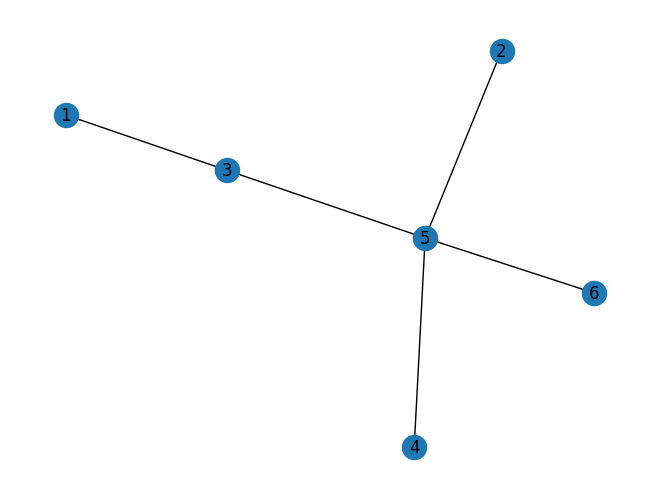

In [5]:
tree = Graph.tree_from_Prufer("3 5 5 5")
print(tree)
tree.plot()

In [6]:
print(tree.preorder(5))

5 2 3 1 4 6


In [9]:
print(tree.postorder(5))

2 1 3 4 6 5


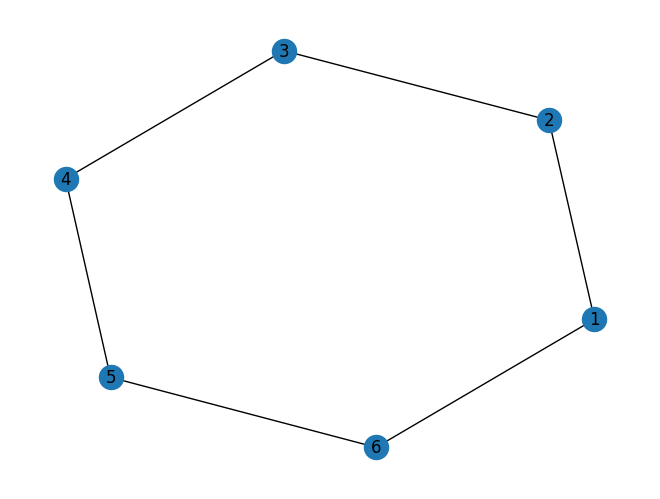

In [10]:
graph1 = Graph.cycle(6)
graph1.plot()

In [11]:
print(graph1.postorder(1))

6 5 4 3 2 1


In [12]:
print(graph1.preorder(1))

RecursionError: maximum recursion depth exceeded

In [33]:
graph = Graph.random_graph(15, 1/5)
print(graph.connected_components())
graphs = graph.ConnectedComponentsGraphs()
for g in graphs:
  print(g)

[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15}, {12}]
1: 7 10
2: 6 8 15
3: 15
4: 5 6 7
5: 4
6: 2 4 14
7: 1 4 8
8: 2 7 10 11 13
9: 11 14
10: 1 8 11 15
11: 8 9 10 13 14
13: 8 11
14: 6 9 11
15: 2 3 10

12:



In [34]:
V = {i for i in range(1, 11)}

In [36]:
print(graph.InducedSubgraph(V))

1: 7 10
2: 6 8
3:
4: 5 6 7
5: 4
6: 2 4
7: 1 4 8
8: 2 7 10
9:
10: 1 8



### Distances in graph (an application of BFS)

In [13]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-11-06 14:11:00--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-11-06 14:11:00--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt’

weighted0.txt       100%[===================>]     114  --.-KB/s    in 0s      

2025-11-06 14:11:01 (2.62 MB/s) - ‘weighted0.txt’ saved [114/114]



A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G



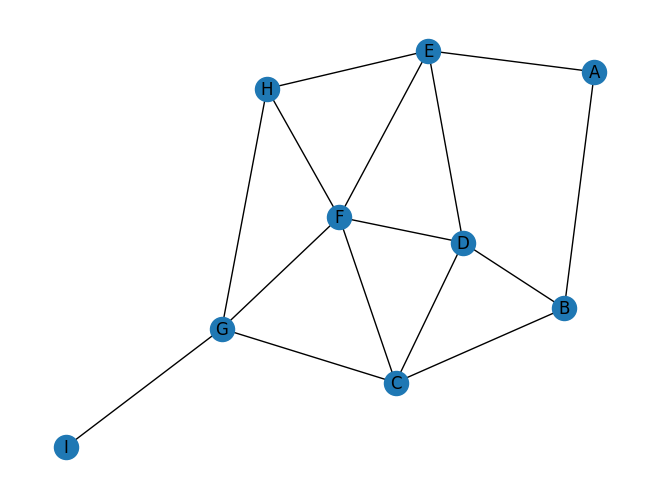

In [22]:
graph1 = Graph.from_edges("weighted0.txt")
print(graph1)
graph1.plot()

In [23]:
print(graph1.distance("A"))

{'A': 0, 'B': 1, 'E': 1, 'C': 2, 'D': 2, 'F': 2, 'H': 2, 'G': 3, 'I': 4}


#### Milgram's experiment &mdash; Small World Phenomenon

We will look whether $G(n, p)$ (eg. $G(4000, 1/600)$) is a good illustration.




In [27]:
n = 4000
p = 1/600

rgraph = Graph.random_graph(n, p)
graph = rgraph.ConnectedComponentsGraphs()[0]
print(len(graph.vertices()))

3991


In [28]:
md = {}
ecc = {}
for v in graph.vertices():
  dist = graph.distance(v)
  ecc[v] = max(dist.values())
  md[v] = sum(dist.values())/len(dist)
print("Radius:", min(ecc.values()), " Diameter: ", max(ecc.values()))
print("Average distance:", sum(md.values())/len(md))

Radius: 6  Diameter:  8
Average distance: 4.606340588046985


### Part 4 (Connected components via DFS)

In [ ]:
graph1 = Graph.random_graph(100, 1/25)
#print(graph1)

In [ ]:
print(len(graph1.connected_components()))
print(graph1.connected_components())

3
[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}, {69}]


### Part 3 (Prufer codes)

In [ ]:
%%writefile tree1.txt
1 3
3 5
2 5
4 5
6 5

Writing tree1.txt


In [ ]:
tree1 = Graph.from_edges("tree1.txt")

In [ ]:
print(tree1)

1: 3
3: 1 5
5: 3 2 4 6
2: 5
4: 5
6: 5



In [ ]:
print(tree1.Prufer())

3 5 5 5


In [ ]:
print(Graph.tree_from_Prufer("3 5 5 5"))

1: 3
2: 5
3: 1 5
4: 5
5: 2 3 4 6
6: 5



In [ ]:
print(Graph.tree_from_Prufer("5 4 3 1"))

1: 3 6
2: 5
3: 4 1
4: 5 3
5: 2 4
6: 1



In [ ]:
print(Graph.tree_from_Prufer("1 1 1 2 3"))

1: 4 5 6 2
2: 1 3
3: 2 7
4: 1
5: 1
6: 1
7: 3



### Part2

In [ ]:
%%writefile edges.txt
a b
b c
b d
d
d c
e
f


Writing edges.txt


In [ ]:
%cat edges.txt

a b
b c
b d
d
d c
e
f


In [ ]:
graph2 = Graph.from_edges("edges.txt")
print(graph2)

a: b
b: a c d
c: b d
d: b c
e:
f:



In [ ]:
graph2.to_neighbourlist("neighbourhood.txt")

In [ ]:
%cat "neighbourhood.txt"

a: b
b: a c d
c: b d
d: b c
e:
f:


In [ ]:
!wget https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt

--2025-10-29 21:54:55--  https://github.com/pgordin/GraphsSN2025/raw/main/weighted0.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt [following]
--2025-10-29 21:54:55--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt’

weighted0.txt       100%[===================>]     114  --.-KB/s    in 0s      

2025-10-29 21:54:55 (8.61 MB/s) - ‘weighted0.txt’ saved [114/114]



In [ ]:
graph3 = Graph.from_edges("weighted0.txt")
print(graph3)

A: B E
B: A C D
E: A D F H
C: B D F G
D: B C E F
F: C D E G H
G: C F H I
H: E F G
I: G



In [ ]:
# it works as well
!wget https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/weighted0.txt

--2025-10-29 21:55:18--  https://raw.githubusercontent.com/pgordin/GraphsSN2025/refs/heads/main/weighted0.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [text/plain]
Saving to: ‘weighted0.txt.1’

weighted0.txt.1     100%[===================>]     114  --.-KB/s    in 0s      

2025-10-29 21:55:18 (4.35 MB/s) - ‘weighted0.txt.1’ saved [114/114]



In [ ]:
graph4 = Graph.random_graph(10, 1/3)
print(graph4)

1:
2: 8 9 10
3: 4 9
4: 3 7 8
5: 6
6: 5 7 10
7: 4 6 8 10
8: 2 4 7 9
9: 2 3 8
10: 2 6 7



In [ ]:
print(Graph.cycle(6))

1: 2 6
2: 1 3
3: 2 4
4: 3 5
5: 4 6
6: 5 1



### Part1

In [ ]:
vertices = ["a", "b", "c", "d"]
matrix = np.array([[0,1,0,0],[1,0,1,0],[0,1,0,1],[0,0,0,1]])
print(vertices)
print(matrix)
print("---------------------------")
print_matrix(vertices, matrix)
print("---------------------------")
print_matrix(None,matrix)

['a', 'b', 'c', 'd']
[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 0 1]]
---------------------------
a :  b
b :  a  c
c :  b  d
d :  d
---------------------------
1 :  2
2 :  1  3
3 :  2  4
4 :  4


In [ ]:
graph_dict = {
  "a": ["b"],
  "b": ["a", "c"],
  "c": ["b", "d"],
  "d": ["c"]
}
print(graph_dict)
print("---------------------------")
print_dict(graph_dict)

{'a': ['b'], 'b': ['a', 'c'], 'c': ['b', 'd'], 'd': ['c']}
---------------------------
a :  b
b :  a  c
c :  b  d
d :  c


In [ ]:
graph1 = Graph.from_matrix(matrix, vertices)
print(graph1)

a: b
b: a c
c: b d
d: d



In [ ]:
print(Graph(graph_dict))  # the same result

a: b
b: a c
c: b d
d: c



In [ ]:
print(graph1.vertices())

['a', 'b', 'c', 'd']


In [ ]:
print(graph1.matrix())

[[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 0 1]]


In [ ]:
graph1.add_vertex("e")
print(graph1)

a: b
b: a c
c: b d
d: d
e:



In [ ]:
graph1.add_edge(["e", "f"])
print(graph1)

a: b
b: a c
c: b d
d: d
e: f
f: e



In [ ]:
graph1.add_arc(["e", "a"])  # breaking the symmetry
print(graph1)

a: b
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.add_edge(["e", "a"])  # restoring the symmetry
print(graph1)

a: b e
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.add_edge(["e", "f"]) # do nothing, an edge already exists
print(graph1)

a: b e
b: a c
c: b d
d: d
e: f a
f: e



In [ ]:
graph1.del_vertex("f")  # removing a vertex
print(graph1)

a: b e
b: a c
c: b d
d: d
e: a



In [ ]:
graph1.add_edge(["e", "e"]) # an error

ValueError: Loops are not allowed!

In [ ]:
graph1.add_arc(["e", "e"]) # OK - loops are allowed in digraphs
print(graph1)

a: b e
b: a c
c: b d
d: d
e: a e



In [ ]:
print(Graph.cycle(6))

1: 2 6
2: 1 3
3: 2 4
4: 3 5
5: 4 6
6: 5 1

